# Dependencies
Install required packages (skip if already installed).

In [1]:
%pip install -r requirements.txt


Note: you may need to restart the kernel to use updated packages.


# Environment setup
Load .env overrides, configure dataset/devices, and load or train the PPO policy + ThresholdRefinementEnv.

In [2]:
import osfrom pathlib import Pathfrom dotenv import load_dotenvfrom stable_baselines3 import PPOfrom envionments.threshold_refinement import ThresholdRefinementEnvfrom utility.dataset import load_pascal_voc2007, load_custom_datasetfrom utility.torch_utils import get_default_devicefrom utility.logging_utils import setup_loggingfrom utility.evaluation import evaluate_policy, summarize_stats, EvalHistoryCallback# Load .env but do not override pre-set values in this runtimeload_dotenv(".env", override=False)setup_logging()# Defaults for more credible runs and GPU usage (Metal on macOS)os.environ.setdefault("RL_DATA_LIMIT", "1000")os.environ.setdefault("RL_TOTAL_TIMESTEPS", "50000")os.environ.setdefault("RL_EVAL_EPISODES", "10")os.environ.setdefault("RL_LEARNING_RATE", "3e-4")os.environ.setdefault("RL_DEVICE", "cpu")os.environ.setdefault("DETECTOR_DEVICE", "mps")# Model-agnostic post-processing knobsos.environ.setdefault("RL_NMS_IOU", "0.7")os.environ.setdefault("RL_MAX_DET", "200")os.environ.setdefault("RL_MAX_NMS_DELTA", "0.02")os.environ.setdefault("RL_MAX_DET_DELTA", "10")os.environ.setdefault("RL_DUPLICATE_PENALTY", "0.05")os.environ.setdefault("RL_DUPLICATE_IOU", "0.8")VOC_ROOT = os.getenv("VOC_ROOT", "data/voc")IMAGE_DIR = os.getenv("IMAGE_DIR")LABEL_DIR = os.getenv("LABEL_DIR")DATA_LIMIT = int(os.getenv("RL_DATA_LIMIT", "1000"))TOTAL_TIMESTEPS = int(os.getenv("RL_TOTAL_TIMESTEPS", "50000"))LEARNING_RATE = float(os.getenv("RL_LEARNING_RATE", "3e-4"))MODEL_PATH = os.getenv("RL_MODEL_PATH", "rl_threshold_tuner.zip")# Stronger env knobs for learning signalENV_KWARGS = {    "max_delta": float(os.getenv("RL_MAX_DELTA", "0.05")),    "max_steps": int(os.getenv("RL_MAX_STEPS", "10")),    "initial_threshold_range": (0.3, 0.7),    "box_count_penalty": float(os.getenv("RL_BOX_COUNT_PENALTY", "0.1")),    "initial_nms_iou": float(os.getenv("RL_NMS_IOU", "0.7")),    "max_det": int(os.getenv("RL_MAX_DET", "200")),    "max_nms_delta": float(os.getenv("RL_MAX_NMS_DELTA", "0.02")),    "max_det_delta": int(os.getenv("RL_MAX_DET_DELTA", "10")),    "duplicate_penalty": float(os.getenv("RL_DUPLICATE_PENALTY", "0.05")),    "duplicate_iou_threshold": float(os.getenv("RL_DUPLICATE_IOU", "0.8")),}POLICY_DEVICE = get_default_device(env_var="RL_DEVICE")DETECTOR_DEVICE = get_default_device(env_var="DETECTOR_DEVICE")image_dir = Path(IMAGE_DIR) if IMAGE_DIR else Nonelabel_dir = Path(LABEL_DIR) if LABEL_DIR else Noneif image_dir and image_dir.exists():    dataset = load_custom_dataset(        image_dir,        label_dir or image_dir,        annotation_format="yolo_txt",        limit=DATA_LIMIT,    )else:    if image_dir:        print(f"IMAGE_DIR={image_dir} not found; falling back to VOC (set IMAGE_DIR/LABEL_DIR correctly to use custom data).")    dataset = load_pascal_voc2007(        VOC_ROOT, image_set="trainval", limit=DATA_LIMIT, download=True    )env = ThresholdRefinementEnv(dataset, device=POLICY_DEVICE, detector_device=DETECTOR_DEVICE, **ENV_KWARGS)def make_eval_callback(model):    return EvalHistoryCallback(        eval_fn=lambda: summarize_stats(            evaluate_policy(                model,                dataset,                episodes=3,                deterministic=True,                device=POLICY_DEVICE,                detector_device=DETECTOR_DEVICE,                env_kwargs=ENV_KWARGS,            )        ),        eval_freq=5000,        name="eval",    )cb = Noneif Path(MODEL_PATH).exists():    try:        model = PPO.load(MODEL_PATH, device=POLICY_DEVICE)        model.set_env(env)        cb = make_eval_callback(model)        print(f"Loaded existing model from {MODEL_PATH}")    except ValueError as err:        print(f"Model at {MODEL_PATH} incompatible with current env ({err}); retraining.")        model = PPO("MlpPolicy", env, verbose=1, learning_rate=LEARNING_RATE, n_steps=512, device=POLICY_DEVICE)        cb = make_eval_callback(model)        model.learn(total_timesteps=TOTAL_TIMESTEPS, callback=cb)        model.save(MODEL_PATH)        print(f"Trained and saved model to {MODEL_PATH}")else:    model = PPO("MlpPolicy", env, verbose=1, learning_rate=LEARNING_RATE, n_steps=512, device=POLICY_DEVICE)    cb = make_eval_callback(model)    model.learn(total_timesteps=TOTAL_TIMESTEPS, callback=cb)    model.save(MODEL_PATH)    print(f"Trained and saved model to {MODEL_PATH}")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | -2.15    |
| time/              |          |
|    fps             | 32       |
|    iterations      | 1        |
|    time_elapsed    | 15       |
|    total_timesteps | 512      |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 20          |
|    ep_rew_mean          | -3.44       |
| time/                   |             |
|    fps                  | 32          |
|    iterations           | 2           |
|    time_elapsed         | 31          |
|    total_timesteps      | 1024        |
| train/                  |             |
|    approx_kl            | 0.014982332 |
|    clip_fraction        | 0.165       |
|    clip_range           | 0.2         |
|    entropy_loss   

2025-12-15 00:17:40,788 | INFO | utility.evaluation | Evaluation summary: episodes=3 mean_final_iou=0.7588 std_final_iou=0.2588 mean_return=8.0320 mean_steps=14.00
2025-12-15 00:17:40,788 | INFO | utility.evaluation | eval @ 5000 steps: mean_final_iou=0.7588 mean_return=8.0320


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 20          |
|    ep_rew_mean          | 5.58        |
| time/                   |             |
|    fps                  | 40          |
|    iterations           | 10          |
|    time_elapsed         | 127         |
|    total_timesteps      | 5120        |
| train/                  |             |
|    approx_kl            | 0.011052726 |
|    clip_fraction        | 0.0518      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.23       |
|    explained_variance   | 0.0959      |
|    learning_rate        | 0.0003      |
|    loss                 | 2.96        |
|    n_updates            | 90          |
|    policy_gradient_loss | -0.00941    |
|    std                  | 0.99        |
|    value_loss           | 8.09        |
-----------------------------------------
------------------------------------------
| rollout/                |      

2025-12-15 00:19:38,693 | INFO | utility.evaluation | Evaluation summary: episodes=3 mean_final_iou=0.6632 std_final_iou=0.1927 mean_return=13.4934 mean_steps=20.00
2025-12-15 00:19:38,693 | INFO | utility.evaluation | eval @ 10000 steps: mean_final_iou=0.6632 mean_return=13.4934


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 6.89         |
| time/                   |              |
|    fps                  | 41           |
|    iterations           | 20           |
|    time_elapsed         | 247          |
|    total_timesteps      | 10240        |
| train/                  |              |
|    approx_kl            | 0.0057523716 |
|    clip_fraction        | 0.0428       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.15        |
|    explained_variance   | 0.312        |
|    learning_rate        | 0.0003       |
|    loss                 | 5.75         |
|    n_updates            | 190          |
|    policy_gradient_loss | -0.00682     |
|    std                  | 0.963        |
|    value_loss           | 11.7         |
------------------------------------------
-----------------------------------------
| rollout/  

2025-12-15 00:21:35,645 | INFO | utility.evaluation | Evaluation summary: episodes=3 mean_final_iou=0.1452 std_final_iou=0.1554 mean_return=4.6268 mean_steps=20.00
2025-12-15 00:21:35,645 | INFO | utility.evaluation | eval @ 15000 steps: mean_final_iou=0.1452 mean_return=4.6268


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 20          |
|    ep_rew_mean          | 7.48        |
| time/                   |             |
|    fps                  | 41          |
|    iterations           | 30          |
|    time_elapsed         | 367         |
|    total_timesteps      | 15360       |
| train/                  |             |
|    approx_kl            | 0.009716389 |
|    clip_fraction        | 0.0934      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.12       |
|    explained_variance   | 0.569       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.94        |
|    n_updates            | 290         |
|    policy_gradient_loss | -0.0137     |
|    std                  | 0.955       |
|    value_loss           | 6.39        |
-----------------------------------------
-----------------------------------------
| rollout/                |       

2025-12-15 00:23:31,612 | INFO | utility.evaluation | Evaluation summary: episodes=3 mean_final_iou=0.2788 std_final_iou=0.2824 mean_return=5.1088 mean_steps=20.00
2025-12-15 00:23:31,613 | INFO | utility.evaluation | eval @ 20000 steps: mean_final_iou=0.2788 mean_return=5.1088


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 7.01         |
| time/                   |              |
|    fps                  | 42           |
|    iterations           | 40           |
|    time_elapsed         | 486          |
|    total_timesteps      | 20480        |
| train/                  |              |
|    approx_kl            | 0.0057070814 |
|    clip_fraction        | 0.0891       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.07        |
|    explained_variance   | 0.488        |
|    learning_rate        | 0.0003       |
|    loss                 | 2.38         |
|    n_updates            | 390          |
|    policy_gradient_loss | -0.0105      |
|    std                  | 0.942        |
|    value_loss           | 7.01         |
------------------------------------------
Trained and saved model to rl_threshold_tuner.zip


# Evaluate policy
Run evaluation rollouts on the dataset and print summary IoU stats.

2025-12-15 00:23:45,147 | INFO | utility.evaluation | Evaluation summary: episodes=5 mean_final_iou=0.6679 std_final_iou=0.3548 mean_return=13.2152 mean_steps=20.00


Episodes: 5
Mean final IoU: 0.6679 +/- 0.3548
Mean return: 13.2152
Mean steps: 20.00
Per-episode final IoUs: [0.0335, 0.5316, 0.9466, 0.9829, 0.8448]


<Axes: title={'center': 'Threshold trajectory per evaluation episode'}, xlabel='Step', ylabel='Confidence threshold'>

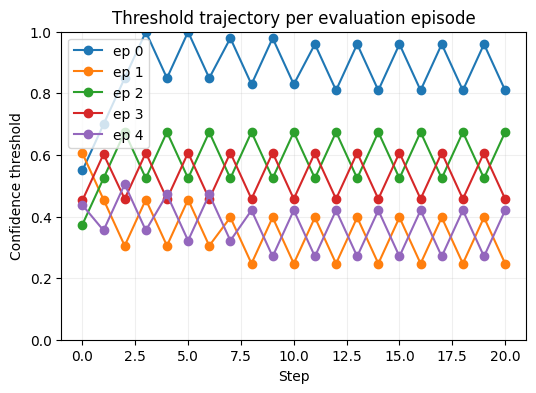

In [3]:
import os

from dotenv import load_dotenv
from utility.evaluation import evaluate_policy, summarize_stats, plot_threshold_trajectories

load_dotenv(".env", override=False)
os.environ.setdefault("RL_EVAL_EPISODES", "10")
EVAL_EPISODES = int(os.getenv("RL_EVAL_EPISODES", "10"))

stats = evaluate_policy(
    model,
    dataset,
    episodes=EVAL_EPISODES,
    device=POLICY_DEVICE,
    detector_device=DETECTOR_DEVICE,
    env_kwargs=ENV_KWARGS,
)
summary = summarize_stats(stats)
print("Episodes:", summary["episodes"])
print(f"Mean final IoU: {summary['mean_final_iou']:.4f} +/- {summary['std_final_iou']:.4f}")
print(f"Mean return: {summary['mean_return']:.4f}")
print(f"Mean steps: {summary['mean_steps']:.2f}")
print("Per-episode final IoUs:", [round(s.final_iou, 4) for s in stats])

plot_threshold_trajectories(stats)


# Per-episode diagnostics
Plot threshold, IoU, and reward trajectories, plus the final IoU distribution.

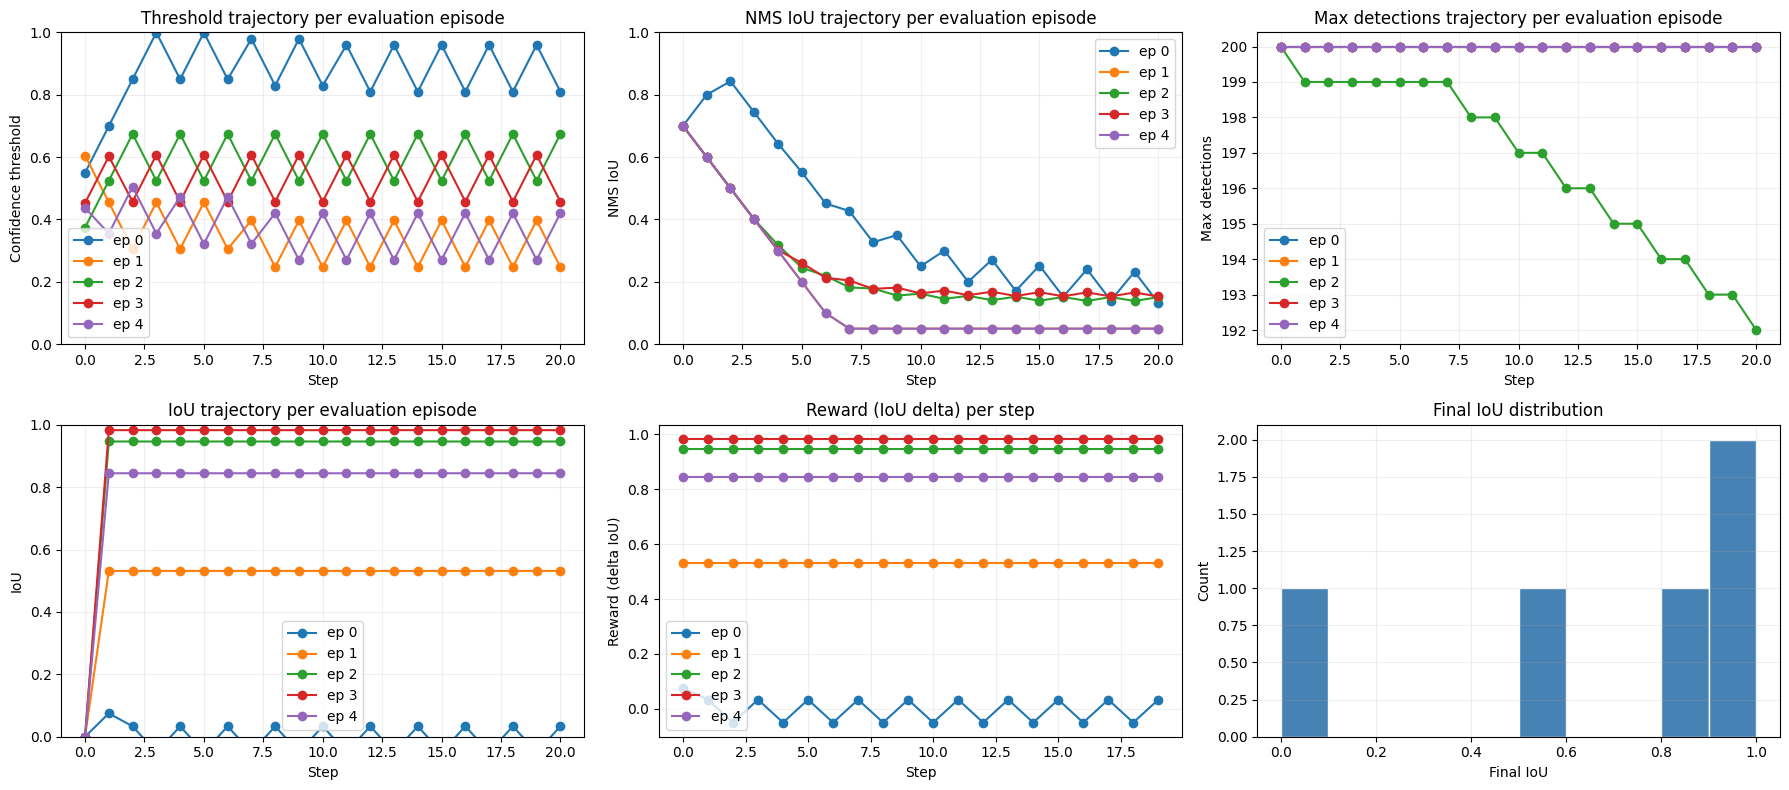

In [4]:
import matplotlib.pyplot as plt
from utility.evaluation import (
    plot_threshold_trajectories,
    plot_iou_trajectories,
    plot_reward_trajectories,
    plot_final_iou_histogram,
    plot_nms_trajectories,
    plot_max_det_trajectories,
)
fig, axes = plt.subplots(2, 3, figsize=(18, 8))
plot_threshold_trajectories(stats, ax=axes[0, 0])
plot_nms_trajectories(stats, ax=axes[0, 1])
plot_max_det_trajectories(stats, ax=axes[0, 2])
plot_iou_trajectories(stats, ax=axes[1, 0])
plot_reward_trajectories(stats, ax=axes[1, 1])
plot_final_iou_histogram(stats, ax=axes[1, 2])
plt.tight_layout()


# Detection-count accuracy vs baseline
Compare how well the policy vs a fixed-threshold YOLO match the ground-truth box count.

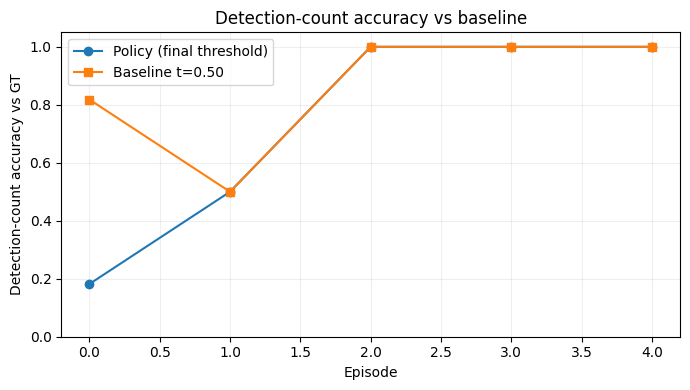

In [5]:
from utility.evaluation import plot_detection_count_accuracy
fig, ax = plt.subplots(figsize=(7,4))
plot_detection_count_accuracy(
    stats,
    dataset,
    baseline_threshold=0.5,
    baseline_nms_iou=float(ENV_KWARGS.get("initial_nms_iou", 0.7)),
    baseline_max_det=int(ENV_KWARGS.get("max_det", 200)),
    detector_device=DETECTOR_DEVICE,
    ax=ax,
)
plt.tight_layout()


# Learning curve
Plot mean_final_iou and mean_return tracked during training.

<Axes: title={'center': 'Learning curve (evaluation)'}, xlabel='Timesteps', ylabel='Score'>

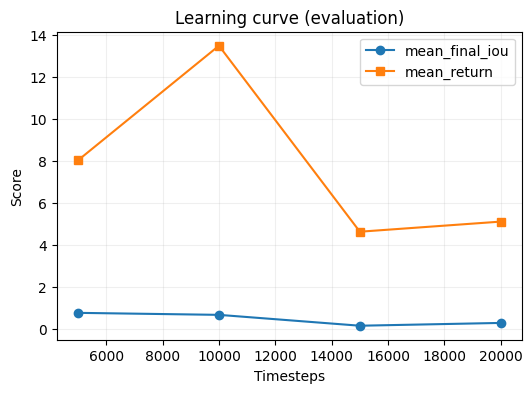

In [6]:
from utility.evaluation import plot_learning_curve

# Plot learning curve from callback history
fig, ax = plt.subplots(figsize=(6,4))
plot_learning_curve(cb.history, ax=ax)


## Compare RL policy vs baseline YOLO

Run quantitative baselines at fixed thresholds and plot qualitative side-by-side detections.

### Quantitative baseline comparison
Evaluate the saved policy against multiple fixed-confidence baselines; adjust COMPAR* env vars to change the sweep.

In [7]:
# import os
# import json
# from dotenv import load_dotenv
# from utility.model_comparison import compare_models

# # Lightweight comparison controls (tune here instead of editing code)
# load_dotenv('.env', override=False)
# COMPARE_DATA_LIMIT = int(os.getenv('COMPARE_DATA_LIMIT', '100'))
# COMPARE_EPISODES = int(os.getenv('COMPARE_EPISODES', '3'))
# COMPARE_THRESHOLDS = [float(t) for t in os.getenv('COMPARE_THRESHOLDS', '0.3,0.5,0.7').split(',')]

# comparison = compare_models(
#     model_path=MODEL_PATH,
#     episodes=COMPARE_EPISODES,
#     dataset_limit=COMPARE_DATA_LIMIT,
#     thresholds=COMPARE_THRESHOLDS,
# )
# print(json.dumps(comparison, indent=2))


### Qualitative policy vs baseline visualization
Show policy detections at the learned threshold alongside a fixed-threshold baseline.

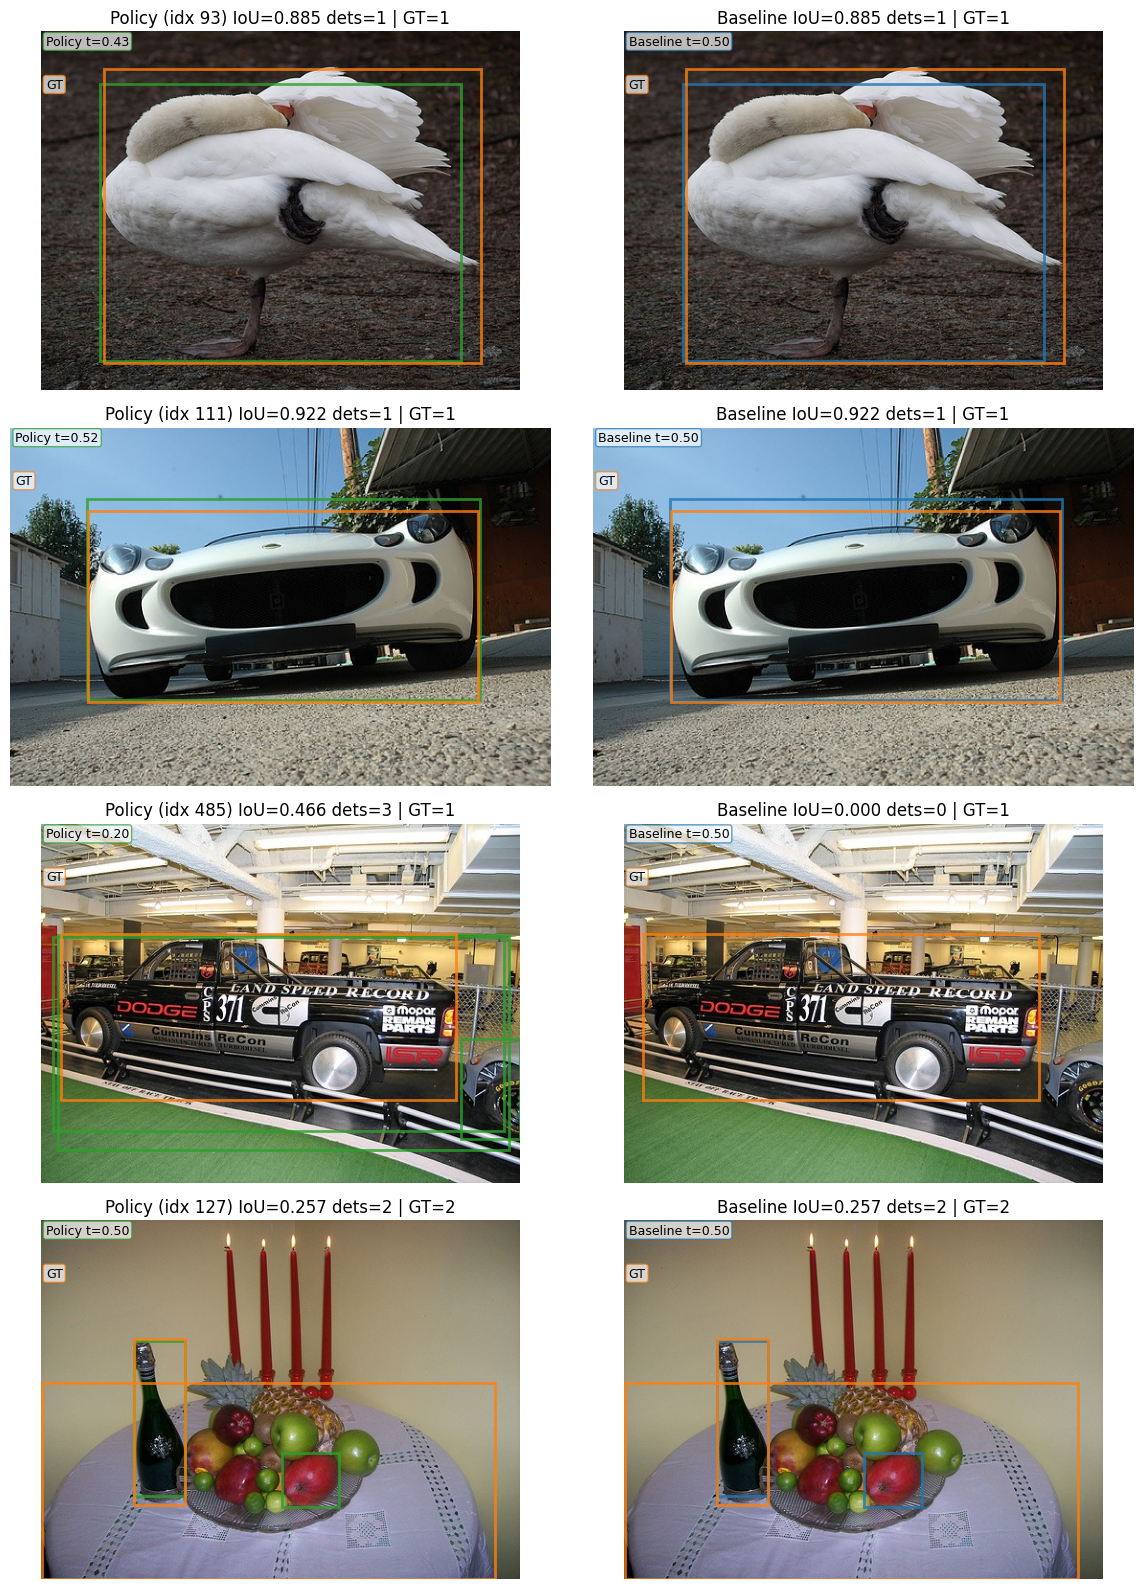

In [8]:
from utility.evaluation import visualize_policy_vs_baseline

fig = visualize_policy_vs_baseline(
    model,
    dataset,
    baseline_threshold=0.5,
    deterministic=True,
    device=POLICY_DEVICE,
    detector_device=DETECTOR_DEVICE,
)
